

## 1. Aprendizaje con regresión lineal.

El modelo de regresión lineal  es una combinación lineal entre variables independientes para obtener otra variable, dependiente de éstas. Lo cual puede resultar bastante simple, pero, hoy en día, ha podido ser aplicado a varios problemas con buenos resultados, como predicción en finanzas y en medicina. Sin embargo, también puede ser un medio para aplicar un modelo más grande, por ejemplo utilizarlo para que, con el resuido, detectar *outliers*, rellenar vacíos/datos incompletos o aprender un *score* para ranquear objetos, lo que haremos en esta sección.

<img src="http://chanakya.ca/wp-content/uploads/2018/05/EstimateMultipleLinearRegressionCoefficientsExample_01.png" height="15%" />


El problema de *learning to rank* es aplicado comúnmente en *Information Retrieval* (IR). Sin embargo, el aprender ésta función puede ser crucial para modelar la importancia de distintos objetos.  


En esta actividad trabajaremos con el problema de predecir el *ranking* mundial de una Universidad en base a distintas características de ésta (dataset *World University Rankings*, a través del siguiente __[link](https://www.kaggle.com/mylesoneill/world-university-rankings)__) en la plataforma de *Kaggle*. En este problema el *ranking* es una medición de qué tan buena es la universidad e intentaremos predecirla a través un modelo simple de regresión lineal. En particular, dentro de los miles de diferentes sistemas de rankings, nacionales e internacionales, entre los cuales comúnmente existen desacuerdos entre ellos, trabajaremos con el ranking ampliamente considerado como uno de las más influyentes y ampliamente observadas: *Times Higher Education World University* .


> a) Cargue los datos a analizar, descargándolos desde la plataforma como se indicó, en formato *dataframe pandas*. Descríbalos adecuadamente, ya sea la variable dependiente o las independientes, si es que lo son.

In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv("timesData.csv")
df.shape


(2603, 14)

In [9]:
df.describe()

,teaching,research,citations,student_staff_ratio,year
count,2603.000000,2603.000000,2603.000000,2544.000000,2603.000000
mean,37.801498,35.910257,60.921629,18.445283,2014.075682
std,17.604218,21.254805,23.073219,11.458698,1.685733
min,9.900000,2.900000,1.200000,0.600000,2011.000000
25%,24.700000,19.600000,45.500000,11.975000,2013.000000
50%,33.900000,30.500000,62.500000,16.100000,2014.000000
75%,46.400000,47.250000,79.050000,21.500000,2016.000000
max,99.700000,99.400000,100.000000,162.600000,2016.000000


## Sobre los datos:


Consideraremos como variable dependiente el puntaje total (total_score) debido a que como se quiere caracterizar mediante un puntaje cada universidad y luego para ponerle un rango, se ordenará de manera descendente para así no utilziar la variable world_rank.
* así consideraremos para la variable dependiente:
    1. total_score
* y como variables independientes:
    1. teaching
    2. international
    3. research 
    4. citations
    5. income 
    6. num_students
    7. student_staff_ratio
    8. international_student
    9. female_male_ratio
* Las variables que no se utilizarán en la regresión alineal excepto para reconocer la universisad en cuestión será:
    1. world_rank (porque es lo mismo que  total_Score ordenado descendiente)
    2. university_name (por ser string)
    3. year (Si bien el año cambia, el ranking no)
* Esta variable es algo especial. Nos servirá para reconocer si existe un sesgo respecto al sector donde están las mejores universidades, esta será
    1. Country

In [10]:
df.head(2)

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011


> b) Debido a la estructura será necesario realizar un leve pre-proceso. Existen vacíos entre los datos o valores '-', por lo que será necesario eliminarlos (*o si piensa una mejor manera de manejar ésto puede hacerlo, se verá reflejado en su nota*). Además de ésto deje los datos con *score unkown* o '-' en un conjunto *target* separado, *unlabeled data* (éste será el objetivo del entrenamiento) ¿Cuántos datos quedan en cada conjunto? 

In [11]:
def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
    return x
df.dropna(axis=0,inplace=True,how='any') #borra nan
df["total_score"] = df["total_score"].apply(lambda x: x.replace('-','unknown')) #rellena 
df = df[~(df == '-').any(axis=1)] #elimina filas con valores nulos

nuevo_df  = pd.get_dummies(df, columns=["country"]) #column to categorical

nuevo_df['female'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[0].apply(convertToInt)
nuevo_df['male'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[1].apply(convertToInt)
nuevo_df['female_male_ratio'] =  np.where(nuevo_df['male'] == 0, 0, nuevo_df['female']/nuevo_df['male']) #si no hay (rellena 0) 
nuevo_df['num_students'] = nuevo_df['num_students'].apply(lambda x: int(str(x).replace(',','')))
nuevo_df['international_students'] = nuevo_df['international_students'].apply(lambda x: int(str(x).replace('%','')))
nuevo_df['student_staff_ratio'] = df['student_staff_ratio']
print(nuevo_df.shape)

df_test = nuevo_df[nuevo_df["total_score"]=='unknown']  #para predecir al final
nuevo_df =  nuevo_df[nuevo_df["total_score"]!='unknown'] #elimina unknown rank..
print(nuevo_df.shape)
nuevo_df.head(10)

(2174, 82)
(954, 82)


,world_rank,university_name,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,...,country_Taiwan,country_Thailand,country_Turkey,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States of America,female,male
1,2,California Institute of Technology,97.7,54.6,98.0,99.9,83.7,96.0,2243,6.9,...,0,0,0,0,0,0,0,1,33,67
2,3,Massachusetts Institute of Technology,97.8,82.3,91.4,99.9,87.5,95.6,11074,9.0,...,0,0,0,0,0,0,0,1,37,63
3,4,Stanford University,98.3,29.5,98.1,99.2,64.3,94.3,15596,7.8,...,0,0,0,0,0,0,0,1,42,58
5,6,University of Cambridge,90.5,77.7,94.1,94.0,57.0,91.2,18812,11.8,...,0,0,0,0,0,0,1,0,46,54
6,6,University of Oxford,88.2,77.2,93.9,95.1,73.5,91.2,19919,11.6,...,0,0,0,0,0,0,1,0,46,54
8,9,Imperial College London,89.2,90.0,94.5,88.3,92.9,90.6,15060,11.7,...,0,0,0,0,0,0,1,0,37,63
12,13,Johns Hopkins University,80.9,58.5,89.2,92.3,100.0,86.4,15128,3.6,...,0,0,0,0,0,0,0,1,50,50
13,14,Cornell University,82.2,62.4,88.8,88.1,34.7,83.9,21424,10.2,...,0,0,0,0,0,0,0,1,48,52
15,15,University of Michigan,83.9,53.3,89.1,84.1,59.6,83.4,41786,9.0,...,0,0,0,0,0,0,0,1,48,52
18,19,University of Pennsylvania,71.8,32.9,82.7,93.6,43.7,79.5,20376,6.5,...,0,0,0,0,0,0,0,1,51,49


Para el  pre-procesamiento de datos se consideraron dos métodos para limpiar las filas que posean un dato atipico respecto a lo que se espera. Esto fue:


A. Mediante la forma establecida:
    1. Se elimina cada entrada nula
    2. cada entrada que posea un "-" se cambia por el valor "unknown"
    3. se categoriza cada pais transformandolos en una columna que posee un valor binario según corresponda.
    4. las entradas que tengan el valor "unknown" de la columna "total score" es nuestro valor que queremos obtener. (datos de prueba).
    5. female_male_ratio se separa mediante un split para tener las proporciones en cantidades enteras.
    
    * la tabla se redujo de 2603 filas a 2174, es decir, ¡se eliminaron 429 filas!
    
B. Mediante nuestra propuesta:

            * En Machine Learning la información es muy importante al momento de generar un entrenamiento y si  más aún cuando se eliminan 429 filas y que los datos no reconocidos se aproxime directamente por un cero. por lo que mediante esta propuesta se buscará obtener un valor cercano al que se pretende para tener más información en nuestro entrenamiento que afecte poco al desarrollo de nuestra regresión lineal siguiendo los siguientes pasos:
            1. Sea n la posicion de la fila que falta, llamaremos filas vecinas a n-1 y n+1.
            2. respecto a los vecinos más cercanos al igual que en piecewise interpolation se calcula el punto medio entre las dos variables considerando un reescale dependiendo de la diferencia entre el total score para reducir el lugar de posibilidades para donde se encontrará el punto que intentamos hallar.
            3. A través de la diferencia del error se obtendrá un intervalo de confianza sobre el cual estará el valor más cercano al faltante
            4. se buscará el vecino más cercano para definir el único signo a considerar.
            5. sobre dicho intervalo se aplicará una función random para obtener nuestro valor.
            

          

In [5]:
%%latex
B. En Machine Learning la información es muy valiosa, por tanto, se debe evitar a toda costa la eliminación de filas que se hace en el algoritmo anterior. De esta forma, 
se considera rellenar los valores en blanco con valores cercanos siguiendo el algoritmo que se proporne bajo los siguientes supuestos.

Asumiremos que existe una función $f$ continua y bien definida tal que $f_{i}(x_{1},x_{2},...,x_{n}) = total score(i)$ donde $i$ corresponde a la fila de la tabla y los $x_{j}$
corresponden a los valores numericos de la tabla a utilizar en nuestra regresión. dado que independiente del error de nuestra regresión, la función será continua.

Si falta un dato, sin perdida de generalidad, supongamos que nos falta uno y será de la forma $x_{2} = '-'$ (previamente todos los valores Nan y distintos, se reemplazarán por '-' para mejorar el analisis de los datos en cuestion)
nuestra meta es buscar un intevalo donde podría pertenecer nuestro valor perdido. Esto en teoría no debería aumentar el error en la estimación, sino debiese quitar un poco de peso a algunas variables, por eso se decidió utilziar este método, ya que de por si es dinamico.

Nuestro primer objetivo es encontrar los valores más cercanos al $totalscore$ de nuestra variable perdida para ver sobre cual posee un valor más cercano, para así tener más presición sobre el valor que podría tomar. Esto resulta fácil por el hecho de que el ranking esta ordenado desde el primero hasta el último, pero por otra parte surge un nuevo inconveniente y es que alguno de los valores más cercanos tambien este perdido por lo que se pueden contemplar dos opciones:

- iterar las columnas ya sea la superior o la inferior hasta hallar un valor que nos sirva ( esta se uso)
- pasar hasta encontrar un valor perdido tal que la superior e inferior existan, pero considerando un rango maximo para las iteraciones (a lo más 2 ó 3) y luego seguir iterando hasta que ninguno quede con algun dato vacio.

luego para ver hacia que valor se acerca más se considera una particion sobre el intervalo en cuestion entre el valor superior e inferior, y $\nabla$ como la proporcion entre el valor más grande y el mas chico del score, de modo que entre más cercano a 1, más cercano es al superior o al cero al inferior. 



          $$ \nabla_i = \frac{(|y[i-1] - y[i+1]|)}{(|y[i-1] - y[i+1]| + 0.1}$$
Donde esta proporcion se ve refejada en el totalscore, lo que nos da una aproximacion hacia que valor está más cercano y esto fue obtenido interpolando valores deseados dada una entrada.
Luego para calcular el largo del intervalo a considerar, aparte de la diferencia entre el valor superior en inferior del valor, un coeficiente que entre más variacion habia, mas chico es el intervalo a considerar partiendo desde la proporcion dada por $\nabla$.                                                     
    $$Error_{low} = \sum_{n=0}^{n=8}min\{|x_{n} - x_{n+1}|, |x_{n} - x_{n+1}|\}$$
    $$Error_{high}\sum_{n=0}^{n=8}max\{|x_{n} - x_{n+1}|, |x_{n} - x_{n+1}|\}$$
    calculamos el intervalo de confianza como:
        $$\bar{E} = \frac{Error_{low}}{Error_{high}}$$
        $$\Delta = (|x_{2}[i-1] - x_{2}[i+1]| ))\cdot \bar{E}$$
        Finalmente
        $$x_{2}[i] \in B(x_{2}[i-1] - x_{2}[i+1]|)\nabla_i,\Delta)        $$
        obteniendolo considerando un valor al azar.
        
        
        

<IPython.core.display.Latex object>

> c) Cree las matrices de cada conjunto con las que trabajará. Además de ésto separe el conjunto de pruebas fijo que se utilizará, recuerde que éste no puede ser utilizado. Si estima conveniente también cree conjunto de validación.

In [12]:
Y = nuevo_df['total_score'].values
X = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).values
X_test = df_test.drop(["total_score","world_rank","university_name"],axis=1).values
Y = Y.astype('float32')
X = X.astype('float32')
X_test = X_test.astype('float32')
X.shape
#X_train = X.sample(600)




(954, 79)

Aquí más que nada se consideró el resultado del funcional en cuestión como "Y" y las componentes de su entrada como "X". También se consideró la variable "X_test", la cual consiste en todos los valores tales que no poseen el valor que entrega el funcional que tratamos de buscar en la regresión.

Nota: Se dice que f es un funcional si f:R^n -> R.


In [30]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
Y_train = Y #if you want to create val!

>d) Normalice los datos antes de trabajar. Explique la importancia/conveniencia de realizar ésto.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
#scaler = StandardScaler(with_mean=True, with_std=True)
#scaler.fit(y_train)
#y_train_scaled = scaler.transform(y_train)
X_test_scaled = scaler.transform(X_test)

La importancia de normalizar radica en igualar el peso de cada variable con respecto de otra para evitar que nuestro algoritmo de machine learning se predisponga a un overfitting. Además facilita el procesamiento de información en cuestión.

> e) Realice una regresión lineal de mı́nimos cuadrados básica. Mida el residuo de cada predicción en cada dato y haga un gráfico de éste ¿Qué indica lo observado?

C:\Users\kzep\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


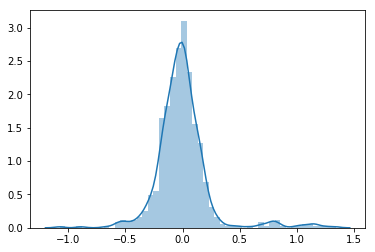

In [17]:
from sklearn.linear_model import LinearRegression as LR
linreg = LR(fit_intercept=True, n_jobs=1)
linreg.fit(X_train_scaled,y_train)

import seaborn as sns
res = y_train-linreg.predict(X_train_scaled)
sns.distplot(res)

La diferencia de los residuos nos indica la distancia que existe entre los valores observados, es decir, d(y,y'), donde "y" corresponde al valor que se nos entregó en el dataframe e "y'" al valor obtenido a través de una regresión de minimos cuadrados. Esto nos dice que el valor de esa diferencia esta acotada, 0<d(y,y')<3 para todo "y"  simulando una "especie de distribución de los errores en los datos".



> f) Construya una tabla con los pesos, Z-score y F-score correspondientes a cada predictor (variable), compare estos valores. ¿Qué sucede si hacemos un raking de los atributos en base al peso obtenido en la regresión? Compare y comente ¿Qué variables están más correlacionadas con la respuesta? Si usáramos un nivel de significación del 5%. ¿Qué es lo que observa y cuál puede ser la causa?

In [ ]:
#abstract

> g) Calcule la información mútua de los distintos predictores (variables) con respecto a la variable *output* o *target*. Comente con lo calculado anteriormente y si le parece razonable.

In [35]:
from sklearn.feature_selection import mutual_info_regression
minfo_predictor = mutual_info_regression(X_train_scaled,y_train)
print(minfo_predictor)

[0.89072353 0.07113685 0.92365416 0.29753666 0.12396494 0.2211345
 0.24126016 0.26196385 0.31370327 0.21485318 0.18889412 0.20835062
 0.21198265 0.16052754 0.17390641 0.19809296 0.20695692 0.19406192
 0.15947242 0.1780016  0.16040912 0.20887434 0.18354215 0.16611669
 0.17211572 0.18847937 0.15474527 0.17652354 0.18165912 0.17357315
 0.17540066 0.20947343 0.17286874 0.18973348 0.1612801  0.15797964
 0.21076502 0.23283523 0.18175675 0.2141554  0.20376056 0.16632524
 0.17906694 0.16184953 0.18717024 0.18475414 0.2038647  0.18602891
 0.1663082  0.18711222 0.19328888 0.19365549 0.22187888 0.15774267
 0.19193093 0.18899934 0.19561214 0.18245508 0.17491153 0.17188601
 0.18979449 0.1772111  0.15840083 0.17408227 0.17905885 0.17593414
 0.16524539 0.19155657 0.17236597 0.19086062 0.17871366 0.17871712
 0.17463743 0.18832058 0.19566307 0.23497535 0.25203699 0.28764497
 0.29310807]


Si la información mutua es igual a cero, entonces las dos variables en cuestión son independientes entre sí. En este caso comparamos la relación mutua de cada entrada para nuestro funcional respecto a la salida que se tiene, de modo que todas están relacionadas y las de más peso son las primeras (note que en las posiciones a partir de la segunda fila debiesen estar los valores de los paises en la relación

> h)  Construya una función que implemente *Forward Step-wise Selection* (FSS). Es decir, partiendo con un modelo sin predictores (variables), agregue un predictor a la vez, re-ajustando el modelo de regresión en cada paso. Para seleccionar localmente una variable, proponga/implemente un criterio distinto al utilizado en el código de ejemplo. Construya un gráfico que muestre el error de entrenamiento y el error de pruebas como función del número de variables en el modelo. Ordene el eje $x$ de menor a mayor.

selected = %s ... teaching
totalvars=%d, mse = %f (2, 27.585627)
selected = %s ... citations
totalvars=%d, mse = %f (3, 10.429185)
selected = %s ... research
totalvars=%d, mse = %f (4, 2.4416435)
selected = %s ... international
totalvars=%d, mse = %f (5, 0.31502423)
selected = %s ... income
totalvars=%d, mse = %f (6, 0.06944919)
selected = %s ... country_Egypt
totalvars=%d, mse = %f (7, 0.064532675)
selected = %s ... year
totalvars=%d, mse = %f (8, 0.061103567)
selected = %s ... country_United States of America
totalvars=%d, mse = %f (9, 0.059326045)
selected = %s ... num_students
totalvars=%d, mse = %f (10, 0.05894841)
selected = %s ... country_Spain
totalvars=%d, mse = %f (11, 0.058592193)
selected = %s ... country_France
totalvars=%d, mse = %f (12, 0.05836962)
selected = %s ... international_students
totalvars=%d, mse = %f (13, 0.058097094)
selected = %s ... country_New Zealand
totalvars=%d, mse = %f (14, 0.05790925)
selected = %s ... country_Turkey
totalvars=%d, mse = %f (15, 0.057

No handles with labels found to put in legend.


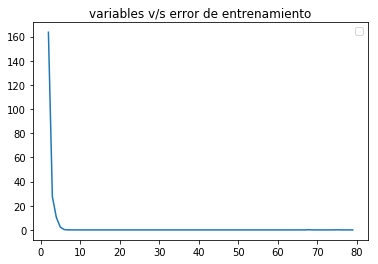

In [59]:
def fss(x, y, names_x):
    p = x.shape[1]-1
    k = min(p, 10000)
    names_x = np.array(names_x)
    error= []
    remaining = range(0, p)
    selected = [p]
    indexes_ls=[]
    current_score = best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = LR(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        #remaining.remove(best_candidate)
        selected.append(best_candidate)
        error.append(mse_candidate)
        indexes_ls.append(len(indexes))
        print ("selected = %s ...",names_x[best_candidate])
        print ("totalvars=%d, mse = %f",(len(indexes),best_new_score))
        
    return selected,indexes_ls,error
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
selected,indexes_ls,error = fss(X_train_scaled,y_train,names_regressors)
plt.plot(indexes_ls,error)
plt.title('Variables v/s error de entrenamiento')
plt.legend()
plt.show()


> i) Ajuste un modelo lineal utilizando “*Ridge Regression*”, es decir, regularizando con la norma $l_2$. Utilice valores del parámetro de regularización $\lambda$ en el rango [$10^0, 10^6$], variando si estima conveniente. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Deje un gráfico sólo para analizar los coeficientes de los países. Describa lo que observa.

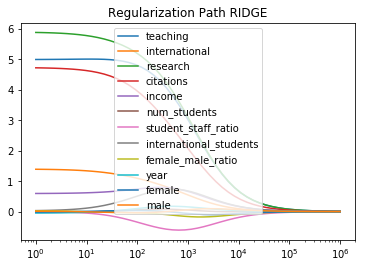

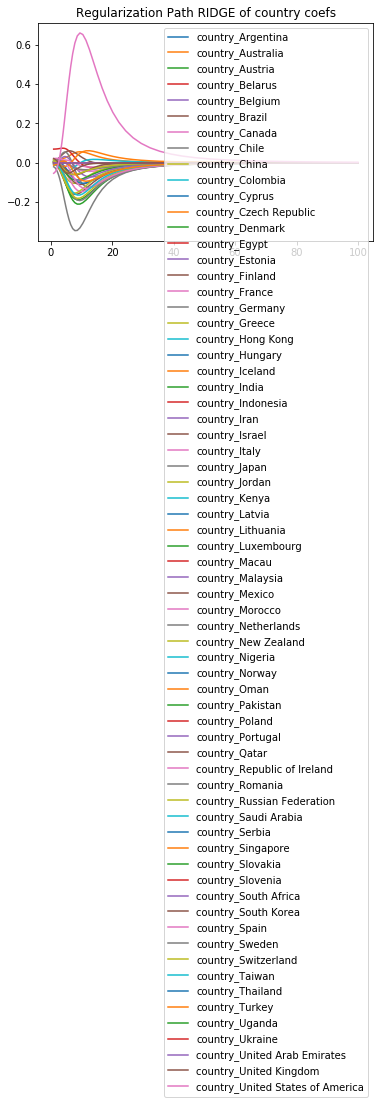

In [29]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
plt.show()
alphas_ = np.logspace(0,2,base=10)
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE of country coefs')
plt.legend()
plt.show()


> j) Ajuste un modelo lineal utilizando el método “*Lasso*”, es decir, regularizando con la norma $l_1$. Utilice valores del parámetro de regularización $\lambda$ en el rango [$10^{-2},10^3$]. Para obtener el código, modifique el ejemplo anterior. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Describa lo que observa. ¿Es más efectivo *Lasso* para seleccionar atributos?

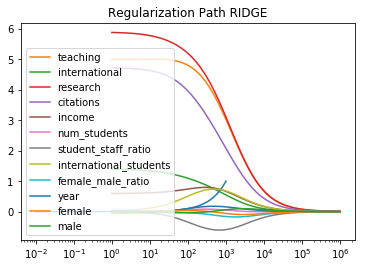

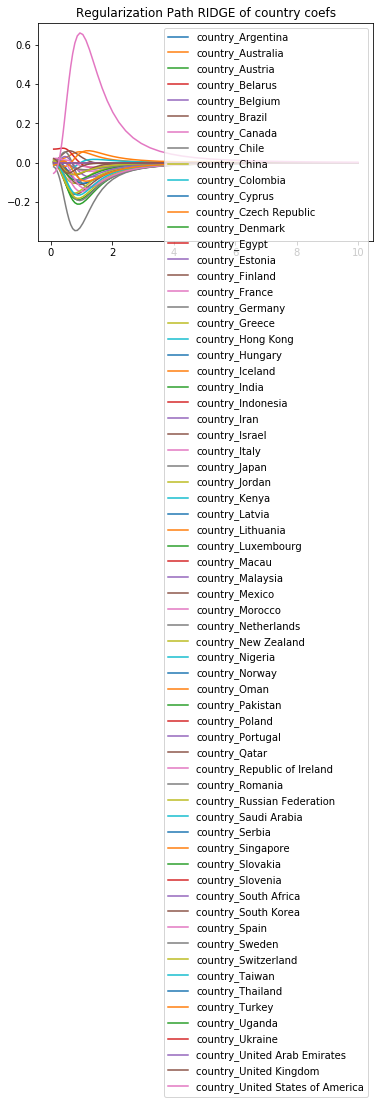

In [63]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pylab as plt
alphas_ = np.logspace(-2,3,base=10)
model = Lasso(fit_intercept=True)

country_alphas_ = np.logspace(-5,0,base=10)
plt.plot(alphas_, country_alphas_)


######################################################

names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
plt.show()
alphas_ = np.logspace(-1,1,base=10)
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE of country coefs')
plt.legend()
plt.show()

> k) Escogiendo uno de los dos métodos regularizadores anteriores, especificando el porqué, construya un gráfico que muestre el error de entrenamiento y el de pruebas como función del parámetro de regularización. Discuta lo que  observa.

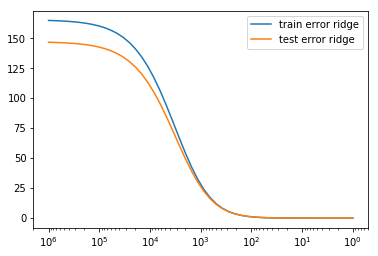

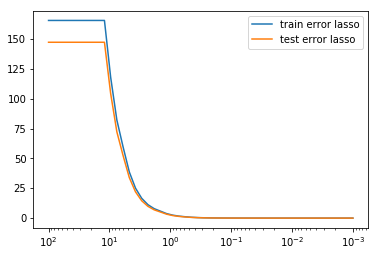

In [65]:
################ Ridge
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test = model.predict(X_test_scaled)
    mse_train.append(np.mean(np.power(yhat_train - y_train, 2)))
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error ridge')
ax.plot(alphas_,mse_test,label='test error ridge')
plt.legend(loc=1)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()






########################## lasso
alphas_ = np.logspace(-3,2,base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test = model.predict(X_test_scaled)
    mse_train.append(np.mean(np.power(yhat_train - y_train, 2)))
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error lasso')
ax.plot(alphas_,mse_test,label='test error lasso')
plt.legend(loc=1)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()



> l) Estime el valor del parámetro de regularización en **alguno** de los modelos anteriores haciendo uso de la técnica validación cruzada con un número de folds igual a $K= 5$ y $K = 10$. Recuerde que para que la estimación sea razonable, en cada configuración (*fold*) deberá reajustar los pesos del modelo. Mida el error real del modelo (ésto es sobre el conjunto de pruebas). Debido a la escala del error puede utilizar auxiliarmente *MAE* como métrica de desempeño. Compare y concluya.

con k =  2
se obtuvo un error de =  232448048.0 

con k =  3
se obtuvo un error de =  978468805.3523418 

con k =  4
se obtuvo un error de =  693126848.0269257 

con k =  5
se obtuvo un error de =  92046918.23562418 

con k =  6
se obtuvo un error de =  1207733264.0378292 

con k =  7
se obtuvo un error de =  515995876.612842 

con k =  8
se obtuvo un error de =  18290599.415242165 

con k =  9
se obtuvo un error de =  352065342.03925276 

con k =  10
se obtuvo un error de =  21644317.941392936 

con k =  11
se obtuvo un error de =  139642834.63374692 

con k =  12
se obtuvo un error de =  21696703.552869067 

con k =  13
se obtuvo un error de =  788235303.4397508 

con k =  14
se obtuvo un error de =  176443876.62813377 

con k =  15
se obtuvo un error de =  1221313877.3945377 

con k =  16
se obtuvo un error de =  447564284.0554043 

con k =  17
se obtuvo un error de =  321612589.159497 

con k =  18
se obtuvo un error de =  32220297.16806753 

con k =  19
se obtuvo un error de =  24

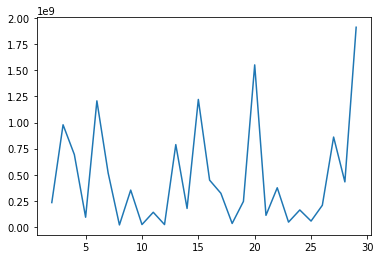

In [88]:
############## K = 10
yhat_test = linreg.predict(X_test_scaled)
mse_test = np.mean(np.power(yhat_test - y_test, 2))
from sklearn.model_selection import KFold
K=10
kf = KFold(n_splits=K)
mse_cv = 0
for train, val in kf.split(X_train_scaled):
    linreg = LR(fit_intercept=True, n_jobs=1)
    linreg.fit(X_train_scaled[train], y_train[train])
    yhat_kfold_val = linreg.predict(X_train_scaled[val])
    mse_fold = np.mean(np.power(yhat_kfold_val - y_train[val], 2))
    mse_cv += mse_fold
mse_cv = mse_cv / K
#print("Error con k = 10,",mse_cv)
...#or MAE
mae_fold = np.mean(np.abs(yhat_kfold_val - y_train[val]))


########### K = 5

yhat_test = linreg.predict(X_test_scaled)
mse_test = np.mean(np.power(yhat_test - y_test, 2))
from sklearn.model_selection import KFold
K=5
kf = KFold(n_splits=K)
mse_cv = 0
for train, val in kf.split(X_train_scaled):
    linreg = LR(fit_intercept=True, n_jobs=1)
    linreg.fit(X_train_scaled[train], y_train[train])
    yhat_kfold_val = linreg.predict(X_train_scaled[val])
    mse_fold = np.mean(np.power(yhat_kfold_val - y_train[val], 2))
    mse_cv += mse_fold
mse_cv = mse_cv / K
#print("Error con K = 5,",mse_cv)

############################## K = 20

yhat_test = linreg.predict(X_test_scaled)
mse_test = np.mean(np.power(yhat_test - y_test, 2))
from sklearn.model_selection import KFold
K=20
kf = KFold(n_splits=K)
mse_cv = 0
for train, val in kf.split(X_train_scaled):
    linreg = LR(fit_intercept=True, n_jobs=1)
    linreg.fit(X_train_scaled[train], y_train[train])
    yhat_kfold_val = linreg.predict(X_train_scaled[val])
    mse_fold = np.mean(np.power(yhat_kfold_val - y_train[val], 2))
    mse_cv += mse_fold
mse_cv = mse_cv / K
#print("Error con K = 20,",mse_cv)
###########################################
x_ls=[]
y_ls = []
for K in range(2,30):
    yhat_test = linreg.predict(X_test_scaled)
    mse_test = np.mean(np.power(yhat_test - y_test, 2))
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=K)
    mse_cv = 0
    for train, val in kf.split(X_train_scaled):
        linreg = LR(fit_intercept=True, n_jobs=1)
        linreg.fit(X_train_scaled[train], y_train[train])
        yhat_kfold_val = linreg.predict(X_train_scaled[val])
        mse_fold = np.mean(np.power(yhat_kfold_val - y_train[val], 2))
        mse_cv += mse_fold
    mse_cv = mse_cv / K
    x_ls.append(K)
    print("con k = ",K)
    y_ls.append(mse_cv)
    print("se obtuvo un error de = ",mse_cv,"\n")
plt.plot(x_ls,y_ls)

Al probar nuestro algoritmo utilizando la técnica de validación cruzada se concluye que es mejor utilizar entre los dos que se dieron es k=10, aunque mirando el grafico existe un minimo que es mucho mejor, este es k=8 y en realidad surge por el hecho de que al cambiar el conjunto de validacion con el de entrenamiento, se pueden encontrar conjuntos de entrenamiento con valores más representativos, aunque a pesar de esto último, debemos recordar que el el error fluctua por el hecho de que estamos buscando una constante reguladora, que minimize el error al ser aplicado, por tanto, cualquier valor en una vecindad de dicho minimo va a ser mayor hasta encontrarse con un maximo para despues bajar. (algo como consecuencia del teorema de bolzano-Weiertrass).

> m) Con el modelo que se piense que es el mejor, en base a todo lo experimentado. Realice el *ranking* de las universidades del que no se tienen etiquetas (*unlabeled data* o *target data*) a través de predecir los datos que se dejaron como *pruebas* y ordenar su score en el *dataframe*.


In [108]:
### Por lasso <3
print("Por Lasso")
alphas_ = np.logspace(-3,2,base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_test = model.predict(X_test_scaled)
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))

univ_chilenas = df_test[df_test["country_Chile"]==1]
rannking_univ_ch = univ_chilenas.sort_values(by="total_score",ascending=False)
ranking = 1
for index,row in rannking_univ_ch.iterrows():
    print("%d - Institucion: %s" %(ranking,row["university_name"]))
    ranking+=1
    


Por Lasso
1 - Institucion: Federico Santa María Technical University
2 - Institucion: Federico Santa María Technical University
3 - Institucion: Austral University of Chile
4 - Institucion: Pontifical Catholic University of Valparaíso
5 - Institucion: University of Santiago, Chile (USACH)


In [109]:
# Por Ridge
print("Por Ridge")
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_test = model.predict(X_test_scaled)
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
univ_chilenas = df_test[df_test["country_Chile"]==1]
rannking_univ_ch = univ_chilenas.sort_values(by="total_score",ascending=False)
ranking = 1
for index,row in rannking_univ_ch.iterrows():
    print("%d - Institucion: %s" %(ranking,row["university_name"]))
    ranking+=1

Por Ridge
1 - Institucion: Federico Santa María Technical University
2 - Institucion: Federico Santa María Technical University
3 - Institucion: Austral University of Chile
4 - Institucion: Pontifical Catholic University of Valparaíso
5 - Institucion: University of Santiago, Chile (USACH)


Finalmente, nuestra universidad es la mejor.